In [12]:
import re
import os
import io
import sys
import random
import warnings
import importlib
import numpy as np
import tf_functions
import pandas as pd
import pickle as pkl
import seaborn as sns
import transformer_v2
import tensorflow as tf
import keras.backend as K
import matplotlib.pyplot as plt
import time

from numba import cuda
from PIL import Image
from collections import Counter
from sklearn import preprocessing
from nltk.corpus import stopwords
from tensorflow.keras import mixed_precision
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard

VitModel = transformer_v2.VitModel

importlib.reload(tf_functions)
warnings.filterwarnings('ignore')
mixed_precision.set_global_policy('mixed_float16')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
stop_words = set(stopwords.words('english'))


### PARAMS DATA
SIZE_IMG = 88

PATCH_SIZE = 8 # SIZE OF THE PATCHES TO BE EXTRACT FROM THE INPUT IMAGES
NUM_PATCHES = (SIZE_IMG // PATCH_SIZE) ** 2

PROJECTION_DIM = 512 #256
TRANSFORMER_LAYERS = 8 #8
NUM_HEADS = 1 #1
TRANSFORMER_UNITS = [
  PROJECTION_DIM * 2,
  PROJECTION_DIM,
] # SIZE OF THE TRANSFORMER LAYERS
MLP_HEAD_UNITS = [ 512 ] # [ 512 ]

### PATHS
VERSION_DS = 2
TF_RECORD_PATH = '../Data/dataset.tfrecord'
DATASET_PATH = '../Bases de Datos/CrisisMMD_v2.0/data_image/' if VERSION_DS == 1 else '../Bases de Datos/Cyclone_Wildfire_Flood_Earthquake_Database/'

### Utils functions

In [ ]:
re_url = re.compile(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?')
re_email = re.compile(r'[\w\.-]+@[\w\.-]+')
re_hashtag = re.compile(r'#([^\s]+)')

def clean_str(string):
  string = re_url.sub('', string)
  string = re.sub(r"[^A-Za-z0-9(),!?\'\#@`]", " ", string)
  string = re.sub(r"\'s", " \'s", string)
  string = re.sub(r"\'ve", " \'ve", string)
  string = re.sub(r"n\'t", " n\'t", string)
  string = re.sub(r"\'re", " \'re", string)
  string = re.sub(r"\'d", " \'d", string)
  string = re.sub(r"\'ll", " \'ll", string)
  string = re.sub(r",", " , ", string)
  string = re.sub(r"!", " ! ", string)
  string = re.sub(r"\(", " \( ", string)
  string = re.sub(r"\)", " \) ", string)
  string = re.sub(r"\?", " \? ", string)
  string = re.sub(r"\s{2,}", " ", string)
  string = string.strip().lower().split()
  string = [ word for word in string if word not in stop_words ]
  return " ".join(string)


In [2]:
def get_class_names(ds_path):
  class_array = []
  for class_name in os.listdir(ds_path):
    class_array.append(class_name)
  return class_array

def get_class_id(class_name):
  return class_array.index(class_name)


def build_example(path_file, class_name):
  n_path = path_file
  if not path_file.endswith('.jpeg') and not path_file.endswith('.jpg'):
    img_array = Image.open(path_file).convert('RGB')
    n_path = path_file.replace('.png', '.jpeg')
    img_array.save(n_path)
    os.remove(path_file)

  path_file = n_path
  img_array = open(path_file, 'rb').read()
  example = tf.train.Example(
    features=tf.train.Features(feature={
    'image': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_array])),
    'class_id': tf.train.Feature(int64_list=tf.train.Int64List(value=[get_class_id(class_name)])),
    'class_name': tf.train.Feature(bytes_list=tf.train.BytesList(value=[class_name.encode('utf-8')])),
    'filepath': tf.train.Feature(bytes_list=tf.train.BytesList(value=[path_file.encode('utf-8')]))
  }))
  return example

def create_tf_record(version, ds_path, out_dir):
  writer = tf.io.TFRecordWriter(out_dir)
  print('Start writing to {}'.format(out_dir))
  if version == 1:
    for class_name in os.listdir(ds_path):
      for date in os.listdir(f'{ds_path}/{class_name}/'):
        for idx, filename in enumerate(os.listdir(f'{ds_path}/{class_name}/{date}/')):
          path_file = os.path.join(ds_path, class_name, date, filename)
          tf_example = build_example(path_file, class_name)
          writer.write(tf_example.SerializeToString())
  elif version == 2:
    for class_name in os.listdir(ds_path):
      for idx, filename in enumerate(os.listdir(f'{ds_path}/{class_name}/')):
        path_file = os.path.join(ds_path, class_name, filename)
        tf_example = build_example(path_file, class_name)
        writer.write(tf_example.SerializeToString())
  writer.close()
  print('Done')


def parse_tfrecord(tfrecord, size):
  x = tf.io.parse_single_example(tfrecord, IMAGE_FEATURE_MAP)
  x_train = tf.image.decode_jpeg(x['image'], channels=3)
  x_train = tf.image.resize(x_train, (size, size))
  x_train = preprocess_input(x_train, mode='tf')

  class_id = x['class_id']
  if class_id is None:
    class_id = -1
  y_train = tf.cast(class_id, tf.int64)

  return ( x_train, y_train )

def load_tfrecord_dataset(file_pattern, size):

  files = tf.data.Dataset.list_files(file_pattern)
  dataset = files.flat_map(tf.data.TFRecordDataset)
  dataset = dataset.map(lambda x: parse_tfrecord(x, size))
  return dataset

IMAGE_FEATURE_MAP = {
  'image': tf.io.FixedLenFeature([], tf.string),
  'class_id': tf.io.FixedLenFeature([], tf.int64),
}

In [ ]:
class_array = get_class_names(DATASET_PATH)
pkl.dump(class_array, open('../Data/class_array.pkl', 'wb'))
create_tf_record(VERSION_DS, DATASET_PATH, TF_RECORD_PATH)

In [10]:
class_array = pkl.load(open('../Data/class_array.pkl', 'rb'))
tf_record = load_tfrecord_dataset(TF_RECORD_PATH, SIZE_IMG)
tf_record = tf_record.cache()

all_ds_len = sum(1 for _ in tf_record)
tf_record = tf_record.shuffle(all_ds_len, seed=SEED)
print(f'Total number of images: {all_ds_len}')

n_train = int(all_ds_len * 0.8)
n_valid = int(all_ds_len * 0.1)
n_test = all_ds_len - n_train - n_valid

train_ds = tf_record.take(n_train)
valid_ds = tf_record.skip(n_train).take(n_valid)
test_ds = tf_record.skip(n_train + n_valid).take(n_test)

Total number of images: 5384


In [13]:
LEARNING_RATE = 0.0000200 #0.0000100
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(
  learning_rate=LEARNING_RATE,
)
input_shape = (None, SIZE_IMG, SIZE_IMG, 3)

model = VitModel(
  transformer_layers=TRANSFORMER_LAYERS,
  patch_size=PATCH_SIZE,
  num_patches=NUM_PATCHES,
  projection_dim=PROJECTION_DIM,
  transformer_units=TRANSFORMER_UNITS,
  num_heads=NUM_HEADS,
  mlp_head_units=MLP_HEAD_UNITS,
  num_classes=len(class_array),
  input_shape=(SIZE_IMG, SIZE_IMG, 3),
)
model.build(input_shape)

check_name = f'checkpoints/{len(class_array)}_{MLP_HEAD_UNITS}_{TRANSFORMER_LAYERS}_trans_{NUM_HEADS}_heads_{NUM_PATCHES}_num_patchs_{PROJECTION_DIM}_{LEARNING_RATE}checkpoint.h5'
logdir = "./logs" + "/" + time.strftime("%Y%m%d_%H-%M-%S")
callbacks = [
  ReduceLROnPlateau(verbose=1),
  #EarlyStopping(patience=10, verbose=1),
  ModelCheckpoint(
    check_name,
    verbose=1,
    monitor='accuracy',
    save_freq='epoch',
    save_best_only=True,
    save_weights_only=True,
  ),
  TensorBoard(log_dir=logdir, histogram_freq=1)
]
model.compile(
  loss=loss,
  optimizer=optimizer,
  metrics=[
    tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
    #tf.keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
  ],
)
BATCH = 64
model.fit(
  epochs=200,
  callbacks=callbacks,
  x=train_ds.batch(BATCH),
  validation_data=valid_ds.batch(BATCH),
)

Epoch 1/200
     68/Unknown - 23s 174ms/step - loss: 2.4964 - accuracy: 0.5055
Epoch 1: accuracy improved from -inf to 0.50546, saving model to checkpoints\3_[512]_8_trans_1_heads_121_num_patchs_512_2e-05checkpoint.h5
68/68 [==============================] - 38s 402ms/step - loss: 2.4964 - accuracy: 0.5055 - val_loss: 1.0965 - val_accuracy: 0.5260 - lr: 2.0000e-05
Epoch 2/200
68/68 [==============================] - ETA: 0s - loss: 1.0921 - accuracy: 0.5127
Epoch 2: accuracy improved from 0.50546 to 0.51265, saving model to checkpoints\3_[512]_8_trans_1_heads_121_num_patchs_512_2e-05checkpoint.h5
68/68 [==============================] - 18s 268ms/step - loss: 1.0921 - accuracy: 0.5127 - val_loss: 1.0986 - val_accuracy: 0.4926 - lr: 2.0000e-05
Epoch 3/200
68/68 [==============================] - ETA: 0s - loss: 1.0886 - accuracy: 0.5134
Epoch 3: accuracy improved from 0.51265 to 0.51335, saving model to checkpoints\3_[512]_8_trans_1_heads_121_num_patchs_512_2e-05checkpoint.h5
68/68 [===

KeyboardInterrupt: 

<AxesSubplot:>

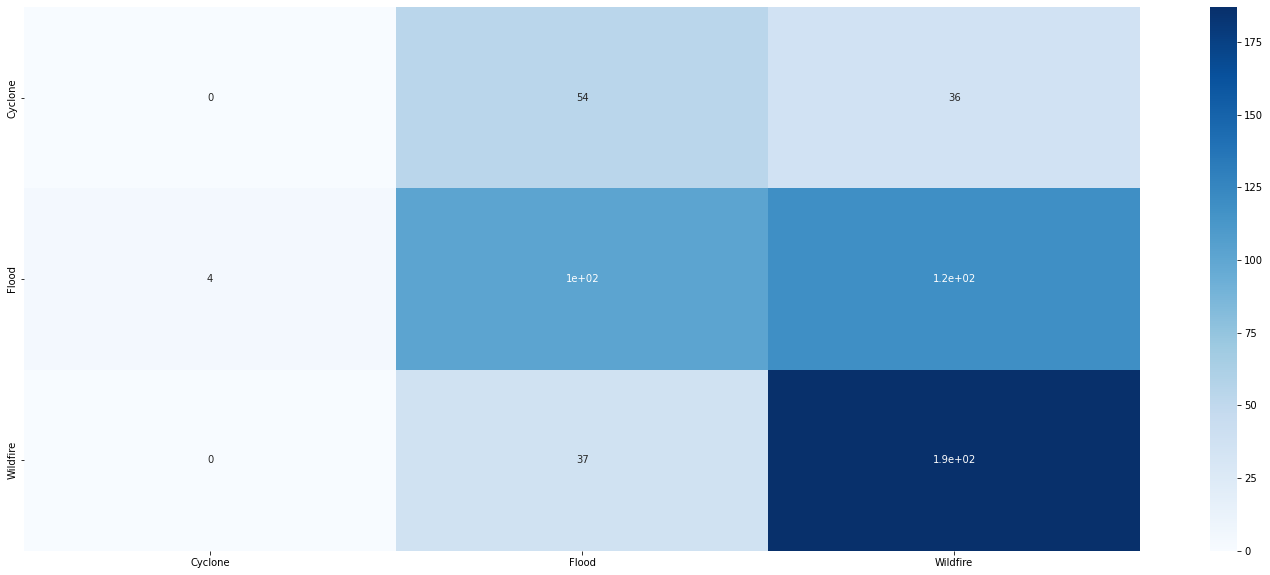

In [8]:
tf_record_eva = test_ds.batch(256)

all_preds = []
all_labels = []
for images, label in tf_record_eva:
  preds = model.predict(images)
  all_labels.extend(label)
  all_preds.extend(np.argmax(preds, axis=1))
del tf_record_eva

confusion_matrix = tf.math.confusion_matrix(all_labels, all_preds, num_classes=len(class_array))

plt.figure(figsize=(25, 10))
sns.heatmap(confusion_matrix.numpy(), annot=True, cmap='Blues', xticklabels=class_array, yticklabels=class_array)

In [ ]:
df = pd.read_csv(
  '../Bases de Datos/crisismmd_datasplit_agreed_label/task_humanitarian_text_img_agreed_lab_dev.tsv',
  sep='\t',
  encoding='utf-8'
)

print('Previous: ', df['tweet_text'].iloc[15])
df['tweet_clean'] = df['tweet_text'].apply(clean_str)
print('After: ', df['tweet_clean'].iloc[15])

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text

In [ ]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [ ]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)

In [ ]:
text_test = list(df['tweet_clean'].values)
len(text_test)

In [ ]:
text_preprocessed = bert_preprocess_model(text_test)
text_preprocessed.keys()

In [ ]:
bert_model = hub.KerasLayer(encoder_url)

In [ ]:
#light test of the layer
result_bert = bert_model(text_preprocessed)
result_bert.keys()

In [ ]:
result_bert['pooled_output']

In [ ]:
result_bert['encoder_outputs']

In [ ]:
result_bert['sequence_output']

In [ ]:
chunks = 100

bert_results = []
for i in range(0, len(text_test), chunks):
  text_chunk = None
  if i == len(text_test) - chunks:
    text_chunk = text_test[i:]
  else:
    text_chunk = text_test[i: i + chunks]

  text_preprocessed = bert_preprocess_model(text_chunk)
  result_bert = bert_model(text_preprocessed)
  bert_results.append(result_bert)

In [ ]:
len(bert_results)

In [ ]:
bert_results[0].keys()

In [ ]:
cuda.select_device(0)
cuda.close()

In [ ]:
#import vgg16
import tensorflow as tf

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
model = VGG19()


In [ ]:
from keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import preprocess_input
import numpy as np

image = load_img('../Data/Naruto_Uzumaki_HD.webp', target_size=(224, 224))

In [ ]:
image = np.array(image)

In [ ]:
image = np.array([image])
image.shape

In [ ]:
image = preprocess_input(image)

In [ ]:
image.shape

In [ ]:
result = model.predict(image)
result[0].shape
#the output is a vector of features (1000)